In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
import time
import datetime as dt
from collections import defaultdict



In [2]:
data = pd.read_csv("C:/Users/Nandini Jain/Desktop/MSEcoSem2/Data_CohortAnalysis.csv")

In [3]:
#changing invoicedate from object to datetime format, using 'mixed' here since some values are in "%m/%d/%Y %H:%M"
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format = 'mixed')

In [4]:
data.head

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Custom

In [5]:
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
data['TransactionMonth'] = data['InvoiceDate'].dt.to_period('M')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         541909 non-null  object        
 1   StockCode         541909 non-null  object        
 2   Description       540455 non-null  object        
 3   Quantity          541909 non-null  int64         
 4   InvoiceDate       541909 non-null  datetime64[ns]
 5   UnitPrice         541909 non-null  float64       
 6   CustomerID        406829 non-null  float64       
 7   Country           541909 non-null  object        
 8   CohortMonth       406829 non-null  period[M]     
 9   TransactionMonth  541909 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(4), period[M](2)
memory usage: 41.3+ MB


In [7]:
data = data.dropna(subset=['CustomerID'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         406829 non-null  object        
 1   StockCode         406829 non-null  object        
 2   Description       406829 non-null  object        
 3   Quantity          406829 non-null  int64         
 4   InvoiceDate       406829 non-null  datetime64[ns]
 5   UnitPrice         406829 non-null  float64       
 6   CustomerID        406829 non-null  float64       
 7   Country           406829 non-null  object        
 8   CohortMonth       406829 non-null  period[M]     
 9   TransactionMonth  406829 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(4), period[M](2)
memory usage: 34.1+ MB


In [9]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

transaction_year, transaction_month,_ = get_date_int(data, 'TransactionMonth')
cohort_year, cohort_month,_ = get_date_int(data, 'CohortMonth')

In [14]:
years_diff = transaction_year - cohort_year
months_diff = transaction_month - cohort_month
data['CohortIndex'] = years_diff * 12 + months_diff + 1
data.head()

C:\Users\Nandini Jain\AppData\Local\Temp\ipykernel_30808\48666775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CohortIndex'] = years_diff * 12 + months_diff + 1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CohortMonth,TransactionMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12,1.0
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1.0


In [15]:
grouping_count = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')
print(cohort_counts.head())

CohortIndex  1.0     2.0     3.0     4.0     5.0     6.0     7.0     8.0     \
CohortMonth                                                                   
1900-01         1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2010-12       947.0   362.0   317.0   367.0   341.0   376.0   360.0   336.0   
2011-01       421.0   101.0   119.0   102.0   138.0   126.0   110.0   108.0   
2011-02       380.0    94.0    73.0   106.0   102.0    94.0    97.0   107.0   
2011-03       440.0    84.0   112.0    96.0   102.0    78.0   116.0   105.0   

CohortIndex  9.0     10.0    11.0    12.0    13.0    1332.0  1342.0  
CohortMonth                                                          
1900-01         NaN     NaN     NaN     NaN     NaN     1.0     1.0  
2010-12       336.0   374.0   353.0   474.0   260.0     NaN     NaN  
2011-01       131.0   146.0   155.0    63.0     NaN     NaN     NaN  
2011-02        98.0   119.0    35.0     NaN     NaN     NaN     NaN  
2011-03       127.0    39.

In [16]:
# --Calculate Retention Rate--
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')

In [17]:
# --Calculate Average Quantity--
grouping_qty = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_qty = grouping_qty['Quantity'].mean()
cohort_data_qty = cohort_data_qty.reset_index()
average_quantity = cohort_data_qty.pivot(index='CohortMonth',
                                     columns='CohortIndex',
                                     values='Quantity')
average_quantity.index = average_quantity.index.strftime('%m-%Y')
average_quantity

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,1332.0,1342.0
CohortMonth,,,,,,,,,,,,,,,
01-1900,1.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.596154,1.959459
12-2010,11.056725,14.603253,14.982141,14.801090,12.943024,14.318095,15.173387,14.759559,16.660455,16.691004,17.344229,12.823263,14.776623,NaN,NaN
01-2011,10.015502,12.573579,12.343099,10.940531,12.234048,14.895373,14.226042,14.385729,11.398390,9.883069,9.090436,9.541612,NaN,NaN,NaN
02-2011,10.830223,12.081317,18.563242,11.959050,11.117223,11.411479,13.346939,12.381845,10.272146,11.945771,12.645977,NaN,NaN,NaN,NaN
03-2011,9.762443,9.924222,12.207366,9.455425,13.579228,12.313412,13.162317,12.177130,10.517494,8.880203,NaN,NaN,NaN,NaN,NaN
04-2011,9.753962,10.105226,9.420617,11.598922,11.488889,8.220785,9.680620,9.289391,7.290019,NaN,NaN,NaN,NaN,NaN,NaN
05-2011,10.866930,9.030276,13.884270,11.805435,10.900268,8.668230,10.148510,7.371571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06-2011,10.327849,13.681576,10.463847,13.275611,10.232734,9.758786,9.255627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07-2011,9.722333,12.700952,7.142646,7.844268,6.013594,7.013233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# --Calculate Average Price--
grouping_price = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_price = grouping_price['UnitPrice'].mean()
cohort_data_price = cohort_data_price.reset_index()
average_price = cohort_data_price.pivot(index='CohortMonth',
                                     columns='CohortIndex',
                                     values='UnitPrice')
average_price.index = average_price.index.strftime('%m-%Y')
average_price

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,1332.0,1342.0
CohortMonth,,,,,,,,,,,,,,,
01-1900,3.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6825,2.545135
12-2010,3.206113,3.183116,3.203559,3.587192,2.931327,4.969632,3.180149,3.222388,3.504112,3.033842,3.302308,2.826403,2.758445,NaN,NaN
01-2011,3.496222,3.650142,3.061950,8.366407,3.156226,3.161185,2.911392,2.745126,2.641303,5.452754,2.874456,2.603719,NaN,NaN,NaN
02-2011,3.343196,4.449731,4.796154,3.147080,2.987471,2.788575,2.808957,3.209261,2.890596,2.938377,3.217126,NaN,NaN,NaN,NaN
03-2011,3.292194,4.975156,3.662518,3.280997,3.609860,2.760767,2.838699,2.794577,2.697759,2.486305,NaN,NaN,NaN,NaN,NaN
04-2011,3.422758,3.960941,3.305169,2.677791,3.017785,2.860244,2.890191,2.800054,2.613616,NaN,NaN,NaN,NaN,NaN,NaN
05-2011,4.636680,3.234354,2.647258,3.167391,2.655884,2.488606,2.614666,2.542818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06-2011,10.399197,3.178243,3.340709,2.828090,2.561434,3.522604,2.285547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07-2011,4.463802,3.480495,2.746260,2.693244,2.404676,2.367032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


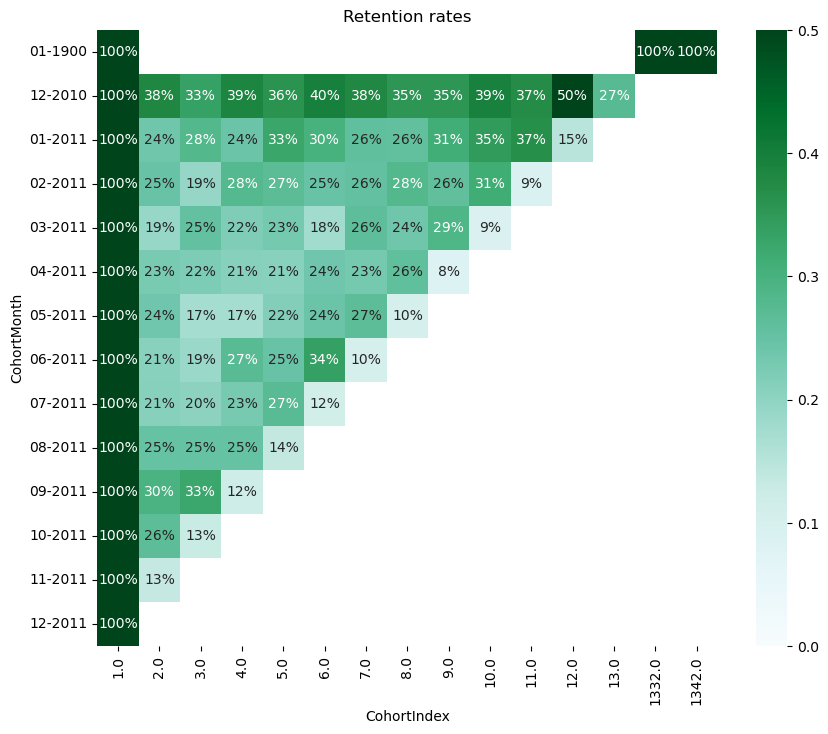

In [19]:
# Plot retention rates
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

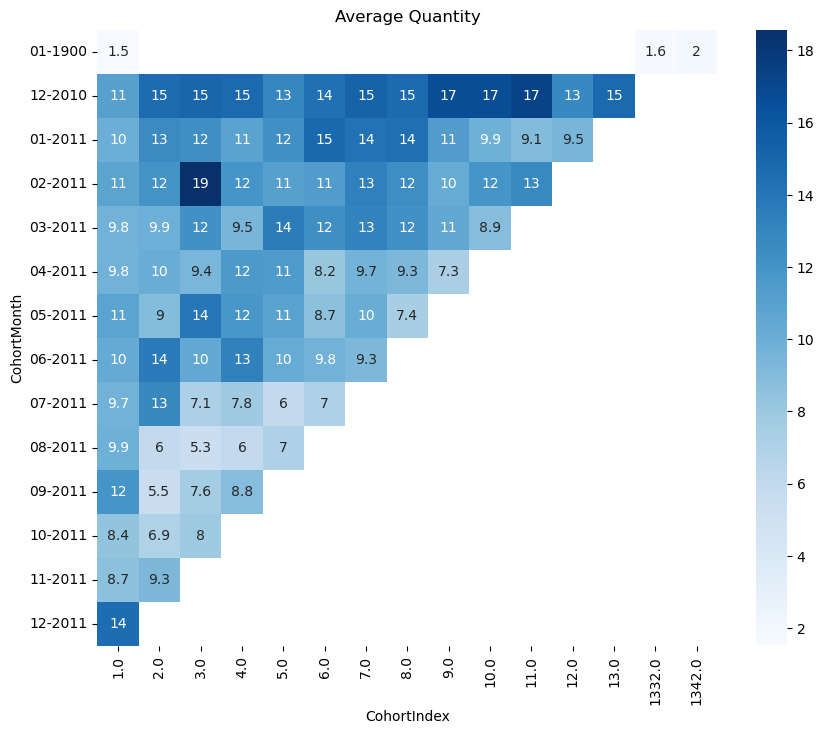

In [20]:
# Plot average quantity
plt.figure(figsize=(10, 8))
plt.title('Average Quantity')
sns.heatmap(data = average_quantity, annot=True, cmap='Blues')
plt.show()

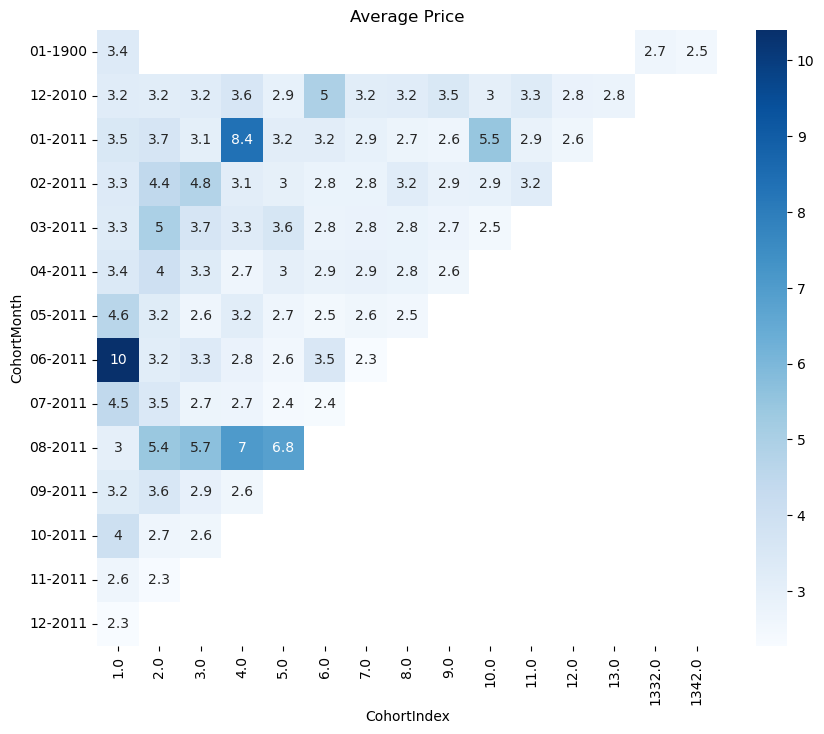

In [21]:
# Plot average price
plt.figure(figsize=(10, 8))
plt.title('Average Price')
sns.heatmap(data = average_price, annot=True, cmap='Blues')
plt.show()

In [22]:
# Grouping by CohortMonth and Item Description to get purchase frequency
cohort_item_prefs = data.groupby(['CohortMonth', 'StockCode'])['Quantity'].sum().reset_index()
# Get top products for each cohort
top_items_per_cohort = cohort_item_prefs.sort_values(['CohortMonth', 'Quantity'], ascending=[True, False]).groupby('CohortMonth').head(5)


top_items_per_cohort

,CohortMonth,StockCode,Quantity
20,1900-01,21326,12.0
55,1900-01,22816,12.0
56,1900-01,22818,12.0
65,1900-01,22983,12.0
92,1900-01,51014C,12.0
...,...,...,...
30671,2011-12,22413,1407.0
31081,2011-12,85152,632.0
30680,2011-12,22457,627.0
30779,2011-12,22727,620.0
